In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import logging
import pprint
import os
import re
import math
import time
from IPython.display import Audio
from IPython.core.display import display

import warnings
warnings.filterwarnings("ignore")

from music21 import converter, corpus, instrument, midi, note, chord, pitch, roman, stream
import mido
from mido import Message, MidiFile, MidiTrack

### 1. Convert note events to timeseries [t,note,vel]
eg. [[0,'C3',23],[2,'D3',56],[35,'D#3',55],[102,'C3',12]]


In [2]:
# returning all note on events from file in the form [[t,note,vel],[t,note,vel],[t,note,vel],...]
def midi_to_timeseries(midiPath):
    
    time_notes = []
#     midiFile = converter.parse(midiPath)
    uniqueTypes = [128,144,176]
    with open(midiPath) as midi_events:
        for line in midi_events:
            processedLine = line.split(" ")
    
            processedLine[0] = int(processedLine[0])
            processedLine[1] = int(processedLine[1], 16)

            if processedLine[1] not in uniqueTypes:
                print("unexpected event type got! ", processedLine[1])

            #    MIDI EVENT TYPES
            #    0x80 (hex)      128 (decimal)    Note Off
            #    0x90 (hex)      144 (decimal)    Note On
            #    0xB0 (hex)      176 (decimal)    Continuous Controller

            # processedLine[2] is note
            processedLine[2] = int(processedLine[2], 16)

            # processedLine[3] is velocity
            processedLine[3] = int(processedLine[3],16)

            if processedLine[1] == 144:
                time_notes.append([processedLine[0], processedLine[2], processedLine[3]])
                
    return time_notes



In [3]:
# generate dataframe of snippets
midiPath = '/Users/snehashah/Desktop/Stagecast/midi-recordings/ladispute.txt'
time_notes = midi_to_timeseries(midiPath)
#plot time_notes?

### STEP 2: Define a simplest similarity metric 

Asumptions & notes: 

-> minimal mistakes (wrong note gets 0 score)

-> similar spped (time is penalized by time diff)

-> time error as absolute not percentage

-> multiple notes can be played together (so not compared by order)

-> done wrt time not note events (timeseries) is this best way to represent notes? maybe as buckets?

-> ignoring vel

-> discriminate between octaves

-> traversing fixed time for targets (doesn't take into account small time changes?)
    
-> fixed absolute threshold 

-> target goes uptil current time - 100ms (to remove same timestamp matches)

-> source hop 500ms, target hop 100ms

##### Questions:
-> Long sequence with lower score or shorter sequence with higher score?

-> When confident in match?

-> Plot best match score vs time?

-> Calculate % time at least 1 match is found

-> Make more recordings to test

-> Idea: for speed change. take any similar note set and scale time by total time to play the set.\

-> Fixed absolute threshold or % of length

-> traversing fixed time for targets (doesn't take into account small time changes?) Is this right?

-> Need to check different values for:
    
    penalty for time change/ min distance/ wrt penalty for wrong note
    
    threshold
    
    min matches

In [5]:
def musical_similarity(tf1, tf2):
    sequence1 = []
    first = tf1[0]
    for el in tf1:
        sequence1.append([el[0]-first[0],el[1]])
        
    sequence2 = []
    first = tf2[0]
    for el in tf2:
        sequence2.append([el[0]-first[0],el[1]])
        
    score = []
    for event1 in range(len(sequence1)):
        for event2 in range(len(sequence2)):
            s = note_similarity(sequence1[event1],sequence2[event2])
#             print(sequence1[event1],sequence2[event2])
            if s != 0:
                score.append(s)
                sequence1[event1] = []
                sequence2[event2] = []
                break
                
    for i in range(len(sequence1) + len(sequence2) - (2*len(score))):
        score.append(0)
        
#     print(sequence1)
#     print(sequence2)
#     print(score)
    return np.mean(score)
        
        
def note_similarity(note1,note2):
    # score is linear with time difference between notes
    
#     strictness = 0.2 # note within 10% time difference
    min_dist = 300 # 300ms is arbitrary audible difference
    
    if (not note1) or (not note2):
        return 0
    if note1 == note2: # exact match!
        return 1
    if note1[1] != note2[1]: # different notes
        return 0
    
    # check if acceptable match
    time_diff = abs(note1[0] - note2[0])
#     print(time_diff)
    if  time_diff < min_dist:
        return 1 - time_diff/min_dist
    else:
        return 0
    
def calculate_similarity(source, targets, startTime):
    matches = []
    count = 0
    for target in targets:
        score = musical_similarity(source, target)
        if score:
            matches.append([startTime, target[0][0], score])
        count += 1
        
    return matches

def calculate_similarity_id(notes, source_id, startTime):
    matches = []
    source_start, source_end = source_id
    note_length = source_start - source_end
    for target_start in range(note_length, source_start+1):
        # pick target_end - by num notes
        target_end = target_start - note_length
        score = musical_similarity(notes[source_end:source_start], notes[target_end:target_start])
        if score:
            matches.append([startTime, notes[target_start][0], score])
        
    return matches

def calculate_similarity_time(notes, source_id, startTime, disp=True):
    matches = []
    last_id = 0
    source_id_start, source_id_end = source_id
    source_start, source_end = startTime, notes[source_id_end][0]
    length_ms = source_start - source_end #in milliseconds
    for target_start in range(length_ms, source_start-500, 100):
        # pick target_end - by time length
        target_end = target_start - length_ms
        for i in range(last_id,len(notes)):
            if notes[i][0] >= target_end:
                target_id_end = i
                break
        for i in range(target_id_end,len(notes)):
            if notes[i][0] > target_start:
                target_id_start = i
                break
        if target_id_end == target_id_start:
            continue
        score = musical_similarity(notes[source_id_end:source_id_start], notes[target_id_end:target_id_start])
        if score:
            if disp and score>0.7:
                display_match(notes, source_id_start, source_id_end, target_id_start, target_id_end, score, source_end, notes[target_id_end][0])
                predict(notes, source_id_start, source_id_end, target_id_start, target_id_end, startTime, target_start)
#                 time.sleep(5)
            matches.append([source_start, target_start, score])
        last_id = target_id_end
        
    return matches

def get_source_targets_index(snips, start_index, min_notes, max_notes, min_time, offset=0):
    for length in range(offset, max_notes-min_notes):
        if snips[length][start_index-min_notes-length][-1][0]-snips[length][start_index-min_notes-length][0][0]>=min_time:
            source = snips[length][start_index-min_notes-length]
            targets = snips[length][0:(start_index-min_notes-length+1)]
            return source, targets
        
    print("Error: Trying to access snippet length > max_notes")
    return None, None

def get_source_targets(snips, start_time, min_notes, max_notes, min_time, offset=0):
    for i in range(len(snips[0])):
        if snips[0][i][0][0] > start_time:
            start_index = i
            break
    else:
        print("Error: Start time too large")
        return None, None
    
    if start_index<3:
        return None, None
    
    return get_source_targets_index(snips, start_index, min_notes, max_notes, min_time, offset)

def get_source_notes_index(notes, start_index, start_time, min_notes, max_notes, min_time):
    for end_index in range(start_index-min_notes, start_index - max_notes - 1, -1):
        if start_time - notes[end_index][0] >= min_time:
            source_id = [start_index,end_index]
            return source_id
        
    print("Error: Trying to access snippet length > max_notes")
    return None

def get_source_notes(notes, start_time, min_notes, max_notes, min_time):
    for i in range(len(notes)):
        if notes[i][0] > start_time:
            start_index = i
            break
    else:
        print("Error: Start time too large")
        return None
    
    if start_index<3:
        return None
    
    return get_source_notes_index(notes, start_index, start_time, min_notes, max_notes, min_time)
   
def get_note(i):
    # convert integer to note
    notes = ['C','C#/Db','D','D#/Eb','E','F','F#/Gb','G','G#/Ab','A','A#/Bb','B']
    return notes[i%12] + str(i//12 - 1)

def get_int(note):
    # convert integer to note
    temp = re.compile("([a-zA-Z]+)([0-9]+)")
    note = temp.match(note).groups()
    notes = {'C':0,'C#/Db':1,'C#':1,'Db':1,'D':2,'D#/Eb':3,'D#':3,'Eb':3,'E':4,'F':5,'F#/Gb':6,'F#':6,'Gb':6,'G':7,'G#/Ab':8,'Ab':8,'G#':8,'A':9,'A#/Bb':10,'A#':10,'Bb':10,'B':11}
    return notes[note[0]] + 12*(int(note[1])+1)

def predict(notes, source_id_start, source_id_end, target_id_start, target_id_end, curr_time, target_time):
    # predicting 100ms of music
    time = target_time
    predeicted = [target_id_start]
    while time < target_time + 100:
        if

def generate_audio(file):
    global piano_audio
    piano_audio = file
    
def display_match(notes, source_start, source_end, target_start, target_end, score, sourceStart, targetStart):
    print("Score: ", score)
    print("Source({st}):  Target({tt}): ".format(st=source_end, tt=target_end))
    for i in range(min(source_start-source_end, target_start-target_end)):
        print(notes[i+source_end][0]-sourceStart, get_note(notes[i+source_end][1]), end=", ")
        print(notes[i+target_end][0]-targetStart, get_note(notes[i+target_end][1]))
    for i in range(target_start-target_end, source_start-source_end):
        print(notes[i+source_end][0]-sourceStart, get_note(notes[i+source_end][1]), end=", \n")
    for i in range(source_start-source_end, target_start-target_end):
        print("        ,",notes[i+target_end][0]-targetStart, get_note(notes[i+target_end][1]))
        
    print("  Next notes: ")
    for i in range(5):
        print(notes[i+source_start][0]-sourceStart,get_note(notes[i+source_start][1]), end=", ")
        print(notes[i+target_start][0]-targetStart,get_note(notes[i+target_start][1]))
        
    print()
        

def play_match(source_start, source_end, target_start, target_end):
    global piano_audio
    #Source
    display(Audio(piano_audio[source_end:source_start], autoplay=True))
    #Target
    display(Audio(piano_audio[target_end:target_start], autoplay=True))
    

IndentationError: expected an indented block (3784535738.py, line 172)

In [316]:
# Zulip example to test similarity score
tf1 = [[-17,60],[-100,62],[-101,64],[-300,60]]
tf2 = [[-20,60],[-50,61],[-101,64],[-102,62],[-307,60]]

musical_similarity(tf1,tf2)

0.7946666666666666

In [365]:
# Snippet note length = 1
minNotes = 8
maxNotes = 30 # max length of snippet to be calculated
minTime = 1500 # min time in ms

# generate dataframe of snippets
snips = []
midiPath = '/Users/snehashah/Desktop/Stagecast/midi-recordings/ladispute.txt'
notes = midi_to_timeseries(midiPath)

for j in range(minNotes, maxNotes + 1):
    ind = j - minNotes
    snips.append([])
    for i in range(len(notes)+1-j):
        snip = notes[i: i+j]
        snips[ind].append(snip)


In [366]:
notes[-1][0]

729285

In [375]:
# calculating similarity

# multiple matches
# sims_arr = []
# for i in range(minTime, snips[0][-1][0][0], 500):
# #     print("\r",end="")
# #     print("i:",i)
#     # only calculate on historical timestamps
#     source, targets = get_source_targets(snips, i, minNotes, maxNotes, minTime)
#     if not source:
#         continue
#     sim = calculate_similarity(source, targets, i)
#     for match in sim:
#         sims_arr.append(match)
        
# for a single match
percentage_matches_thresh = 0
percentage_matches_any = 0
sims_arr = []
source = 1
sourceId = 1
index = 0
for i in range(minTime, notes[-1][0], minTime):
    sims.append([])
    print("\r",end="")
    print("i:",i,end="   ")
    # only calculate on historical timestamps
    offset = 0
    count = notes[-1][0] + 1 # count number of relevant matches
    max_matches = notes[-1][0] # if more matches, increase size of snippet
    while count > max_matches:
#         source, targets = get_source_targets(snips, i, minNotes, maxNotes, minTime + offset)
        sourceId = get_source_notes(notes, i, minNotes, maxNotes, minTime+offset)
        if not source or not sourceId:
            print("Failed for source = ",source, ", source_id = ", sourceId, ", on attempt ", (offset//500))
            if offset>0:
                percentage_matches_any += 1
            break
#         sim = calculate_similarity(source, targets, i)
#         sim = calculate_similarity_id(notes, sourceId, i)
        sim = calculate_similarity_time(notes, sourceId, i)#, disp=False)
        count = 0
        for match in sim:
            if match[2] > 0.7:
                count += 1
#         print("\b",end="")
#         print(len(targets))
        offset += 500
        
#     if count < 2:
#         print("Only 1 match found! (self)")
#         print("1 match",end=", ")
    if source and sourceId and sim:
        percentage_matches_any += 1
        flag = True
        for match in sim:
            sims_arr.append(match)
            if flag and match[2]>0.7:
                percentage_matches_thresh += 1
                flag = False
    else:
        sims_arr.append([i,0,0])
    
    index += 1
    
percentage_matches_thresh /= (notes[-1][0]/minTime)
percentage_matches_any /= (notes[-1][0]/minTime)
print("\n\nPercentage matches found: ", percentage_matches_any)
print("\n\nPercentage matches > 0.7 found: ", percentage_matches_thresh)


i: 1500   Error: Trying to access snippet length > max_notes
Failed for source =  1 , source_id =  None , on attempt  0
i: 3000   Score:  0.75
Source(2):  Target(2): 
0 G3, 0 G3
5 A#/Bb3, 5 A#/Bb3
658 A#/Bb3, 658 A#/Bb3
663 G3, 663 G3
1231 A#/Bb4, 1231 A#/Bb4
1235 D#/Eb3, 1235 D#/Eb3
1800 G3, 
1812 A#/Bb3, 
  Next notes: 
2435 G3, 1800 G3
2462 A#/Bb3, 1812 A#/Bb3
2901 D#/Eb4, 2435 G3
2973 D3, 2462 A#/Bb3
2995 D4, 2901 D#/Eb4

i: 10500   Score:  0.7591666666666665
Source(32):  Target(4): 
0 G3, 0 A#/Bb3
14 A#/Bb3, 5 G3
651 A#/Bb4, 573 A#/Bb4
662 D#/Eb3, 577 D#/Eb3
1261 G3, 1142 G3
1264 A#/Bb3, 1154 A#/Bb3
1868 G3, 1777 G3
1880 A#/Bb3, 1804 A#/Bb3
  Next notes: 
2314 D#/Eb4, 2243 D#/Eb4
2450 D3, 2315 D3
2462 D4, 2337 D4
3044 B3, 2919 B3
3046 G3, 2951 G3

i: 12000   Score:  0.82
Source(37):  Target(8): 
0 A#/Bb3, 0 G3
604 G3, 12 A#/Bb3
616 A#/Bb3, 635 G3
1050 D#/Eb4, 662 A#/Bb3
1186 D3, 1101 D#/Eb4
1198 D4, 1173 D3
1780 B3, 1195 D4
1782 G3, 1777 B3
        , 1809 G3
  Next notes: 
2375 B3

i: 66000   Score:  0.707037037037037
Source(238):  Target(196): 
0 C4, 0 G3
4 G3, 213 D#/Eb5
253 D#/Eb5, 238 D#/Eb4
595 D3, 583 D5
611 D5, 587 D3
626 D4, 595 D4
1203 B3, 1170 G3
1224 G3, 1177 B3
  Next notes: 
1784 B3, 1741 B3
1797 G3, 1768 G3
2361 D3, 2334 D3
2378 B5, 2920 G3
2383 B4, 2930 B3

i: 75000   Score:  0.7148148148148148
Source(277):  Target(214): 
0 C4, 0 G#/Ab3
548 G#/Ab3, 34 C4
579 C4, 606 G#/Ab3
1164 F3, 1179 F3
1171 C6, 1197 C5
1177 C5, 1200 C6
1775 G#/Ab3, 1787 G#/Ab3
1797 C4, 1799 C4
  Next notes: 
2366 G#/Ab3, 2375 G#/Ab3
2385 C4, 2390 C4
2586 F5, 2625 F5
2590 F4, 2626 F4
2971 D#/Eb5, 2959 D#/Eb4

Score:  0.7148148148148148
Source(277):  Target(214): 
0 C4, 0 G#/Ab3
548 G#/Ab3, 34 C4
579 C4, 606 G#/Ab3
1164 F3, 1179 F3
1171 C6, 1197 C5
1177 C5, 1200 C6
1775 G#/Ab3, 1787 G#/Ab3
1797 C4, 1799 C4
  Next notes: 
2366 G#/Ab3, 2375 G#/Ab3
2385 C4, 2390 C4
2586 F5, 2625 F5
2590 F4, 2626 F4
2971 D#/Eb5, 2959 D#/Eb4

Score:  0.7148148148148148
Source(277):  Target(214): 
0 C4

i: 139500   Score:  0.7463888888888889
Source(547):  Target(501): 
0 A#/Bb3, 0 A#/Bb3
44 D#/Eb5, 3 D#/Eb5
310 D#/Eb6, 286 F4
312 F4, 296 D#/Eb6
582 A#/Bb3, 546 A#/Bb3
608 D#/Eb5, 563 D#/Eb5
834 D#/Eb3, 807 D#/Eb3
876 D#/Eb6, 839 D#/Eb6
1177 A#/Bb3, 1134 A#/Bb3
1180 D#/Eb5, 1136 D#/Eb5
1409 D#/Eb4, 
1437 D#/Eb6, 
  Next notes: 
1733 D6, 1394 D#/Eb4
1754 A#/Bb3, 1420 D#/Eb6
2062 F4, 1712 D6
2089 D5, 1733 A#/Bb3
2336 D6, 2018 F4

Score:  0.9041666666666667
Source(547):  Target(501): 
0 A#/Bb3, 0 A#/Bb3
44 D#/Eb5, 3 D#/Eb5
310 D#/Eb6, 286 F4
312 F4, 296 D#/Eb6
582 A#/Bb3, 546 A#/Bb3
608 D#/Eb5, 563 D#/Eb5
834 D#/Eb3, 807 D#/Eb3
876 D#/Eb6, 839 D#/Eb6
1177 A#/Bb3, 1134 A#/Bb3
1180 D#/Eb5, 1136 D#/Eb5
1409 D#/Eb4, 1394 D#/Eb4
1437 D#/Eb6, 1420 D#/Eb6
  Next notes: 
1733 D6, 1712 D6
1754 A#/Bb3, 1733 A#/Bb3
2062 F4, 2018 F4
2089 D5, 2039 D5
2336 D6, 2305 A#/Bb3

Score:  0.9041666666666667
Source(547):  Target(501): 
0 A#/Bb3, 0 A#/Bb3
44 D#/Eb5, 3 D#/Eb5
310 D#/Eb6, 286 F4
312 F4, 296 D#/Eb6


KeyboardInterrupt: 

In [373]:
# choosing only significant scores and storing the new data in sims_plot

sims_arr = np.array(sims_arr)
sims_bool = sims_arr>0.7 # considering a match if score greater than a threshold
sims_plot = sims_arr * sims_bool
sims_plot

array([[  1500.,      0.,      0.],
       [  3000.,   2163.,      0.],
       [  3000.,   2263.,      0.],
       ...,
       [729000., 728270.,      0.],
       [729000., 728370.,      0.],
       [729000., 728470.,      0.]])

<AxesSubplot:title={'center':'Min Snippet Length=8 notes, Min matches=729285'}, xlabel='source_timestamp', ylabel='target_timestamp'>

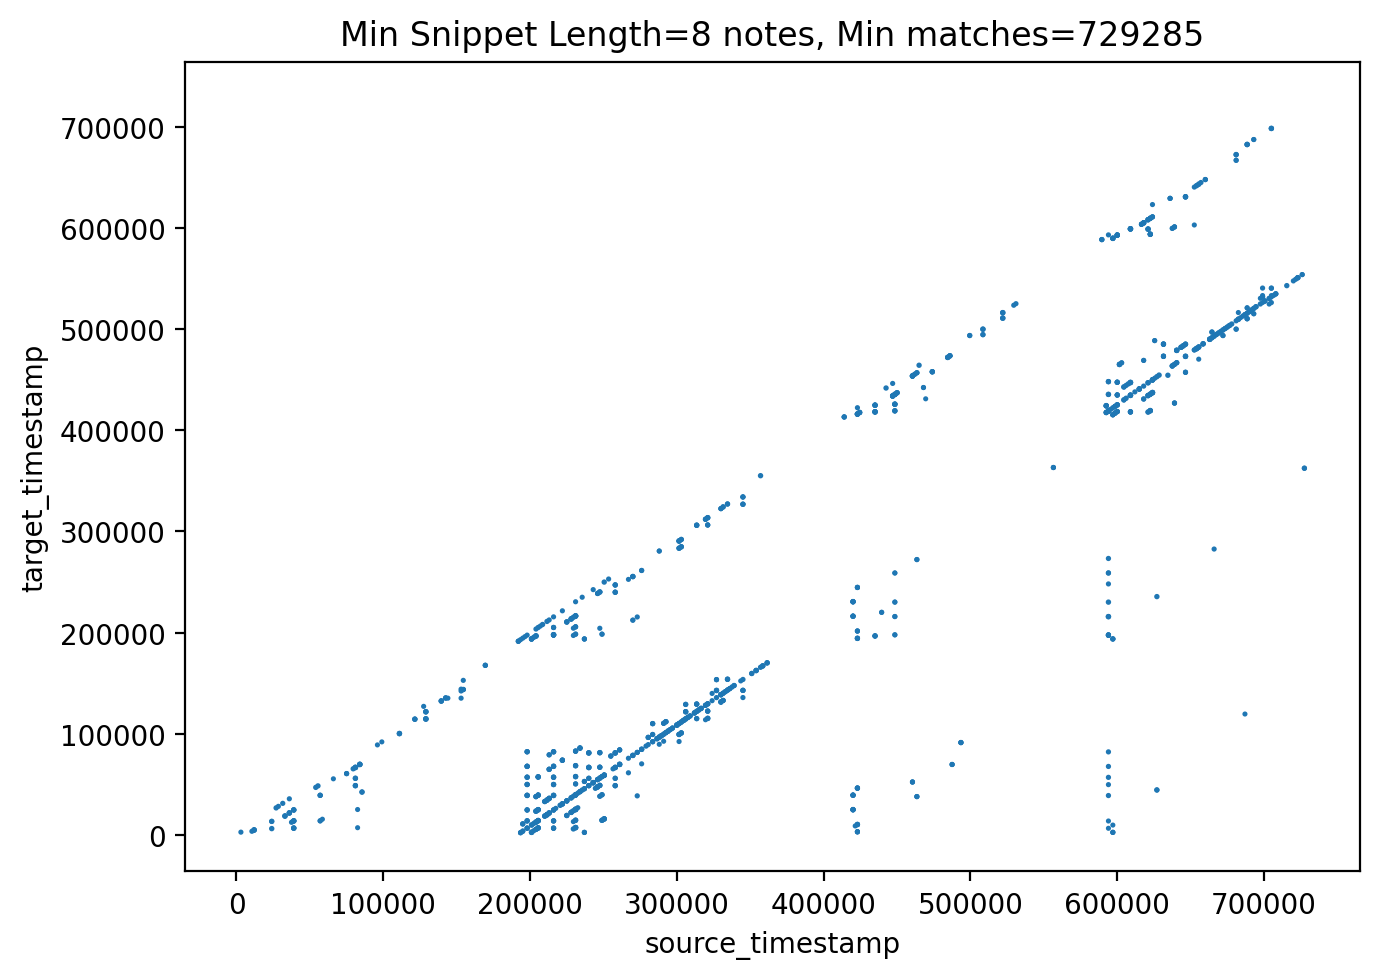

In [374]:
plt.rcParams["figure.figsize"] = [7, 5]
plt.rcParams["figure.autolayout"] = True

simsDF = pd.DataFrame(data=sims_plot, columns=['source_timestamp', 'target_timestamp','score'])
title = "Min Snippet Length=" + str(minNotes) + " notes, Min matches=" + str(max_matches)
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)

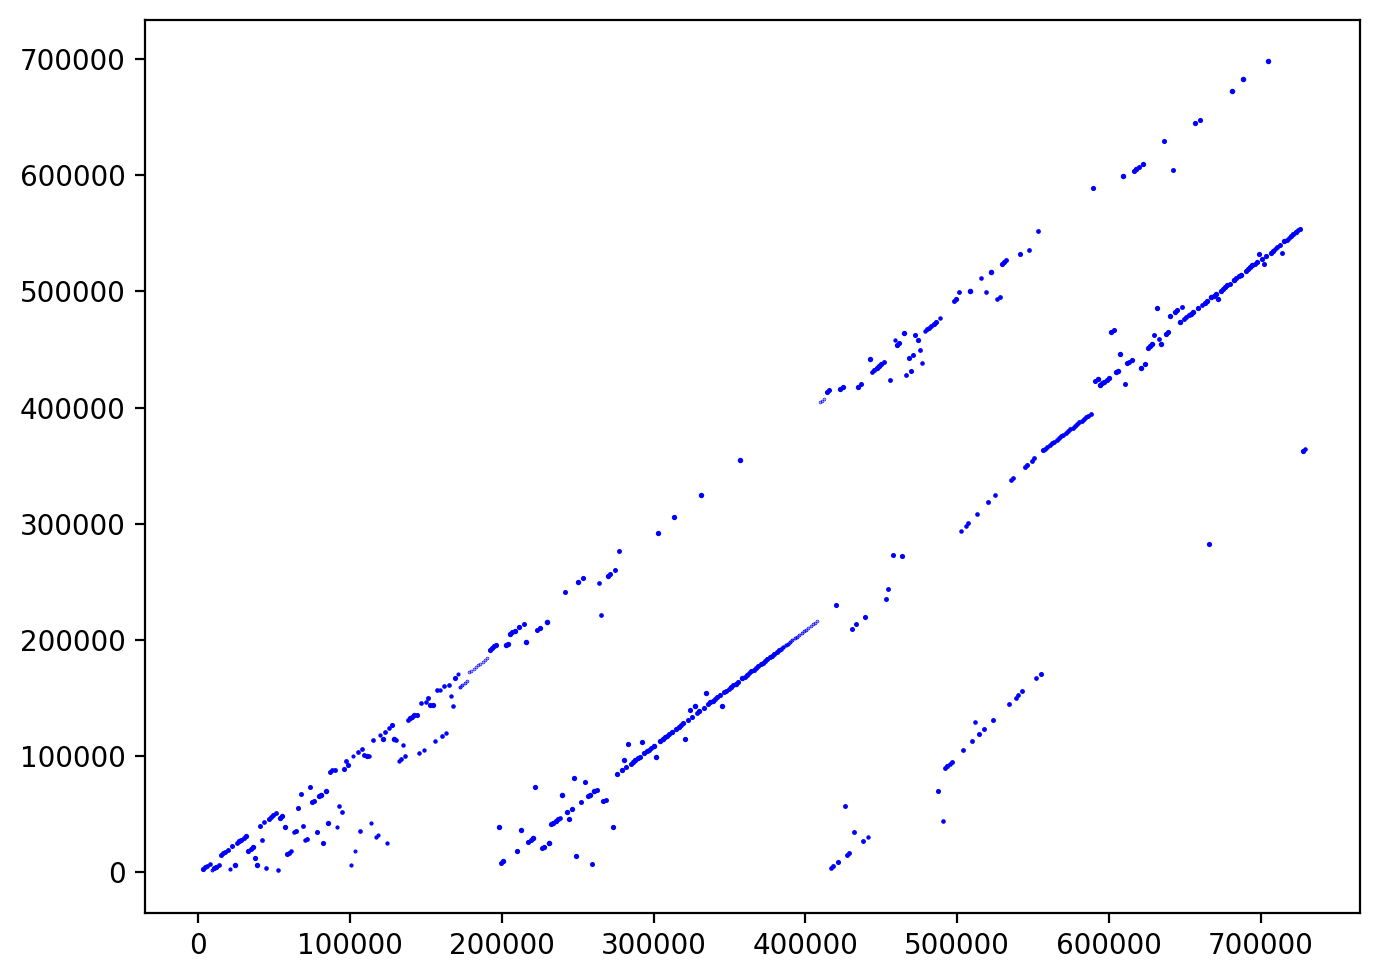

In [371]:
# Plotting best match only

simsDF = pd.DataFrame(data=sims_arr, columns=['source_timestamp', 'target_timestamp','score'])
count = 0
for x in range(minTime, notes[-1][0], minTime):
    y = simsDF.loc[simsDF['source_timestamp'] == x]['score'].idxmax()
    plt.scatter(simsDF['source_timestamp'].loc[y],simsDF['target_timestamp'].loc[y],simsDF['score'].loc[y],c='blue')
    
plt.show()

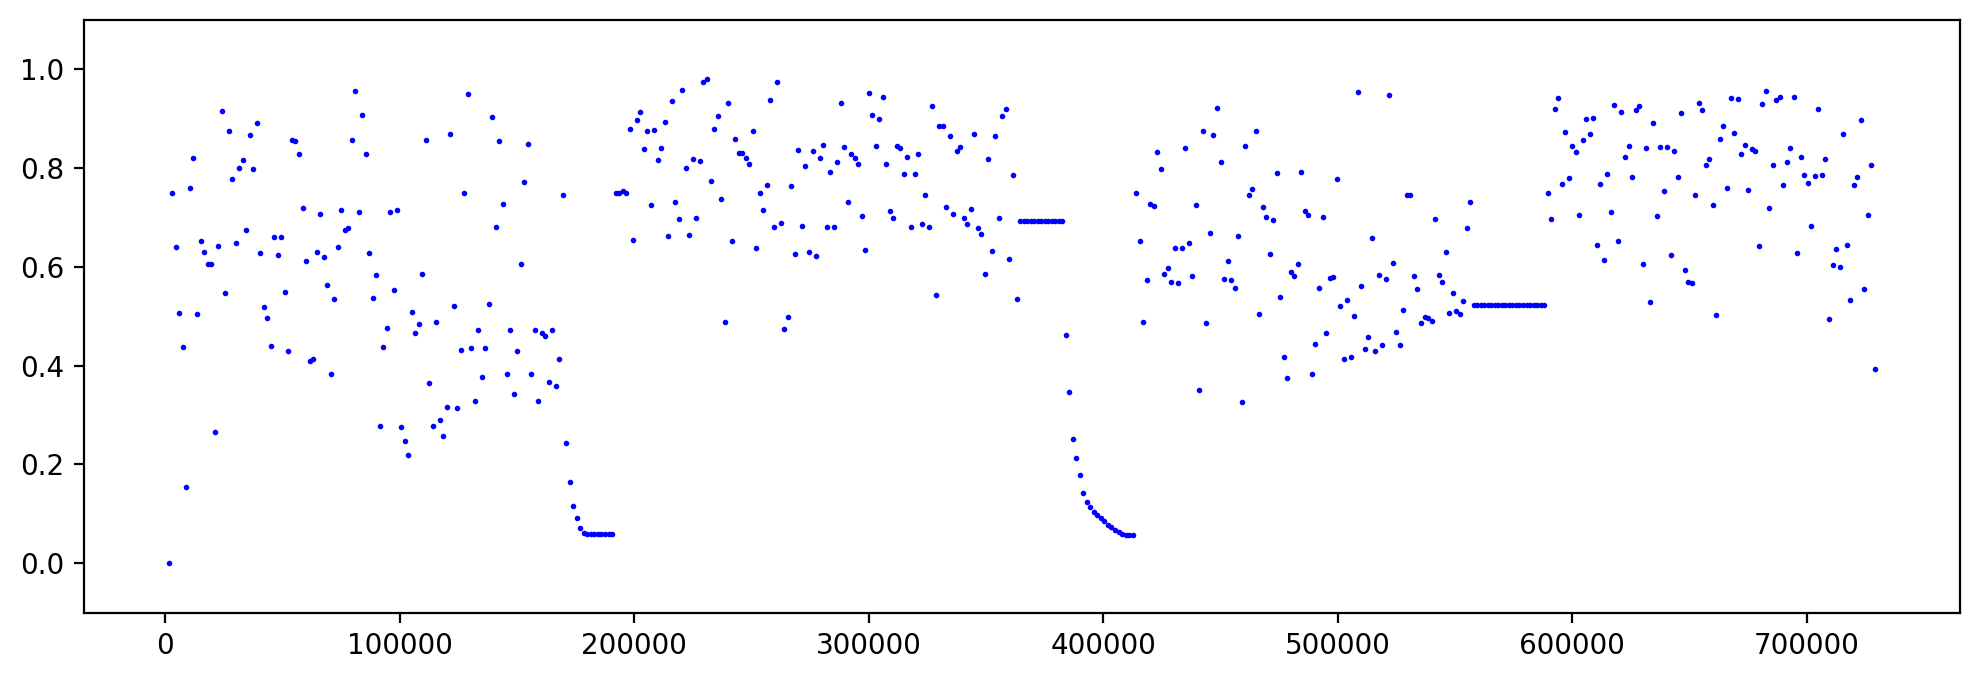

In [372]:
# Plotting best match score 

plt.rcParams["figure.figsize"] = [10, 3.50]
plt.rcParams["figure.autolayout"] = True

simsDF = pd.DataFrame(data=sims_arr, columns=['source_timestamp', 'target_timestamp','score'])
count = 0
for x in range(minTime, notes[-1][0], minTime):
    y = simsDF.loc[simsDF['source_timestamp'] == x]['score'].max()
    if math.isnan(y):
        count += 1
        y = 0
    plt.scatter(x,y,1,c='blue')
    
# print(count)
plt.ylim(-0.1, 1.1)
plt.show()

In [ ]:
# earlier approach - calculate score as sum of scores from minNotes to maxNotes
# too sow for time length 2d array (conversions between types and traveersing)

minNotes = 4
maxNotes = 4
history = 'full'

# generate dataframe of snippets
snips = []
midiPath = '/Users/snehashah/Desktop/Stagecast/midi-recordings/ladispute.txt'
notes = midi_to_timeseries(midiPath)

for j in range(minNotes, maxNotes+1):
    ind = j - minNotes
    snips.append([])
    for i in range(len(notes)+1-j):
        snip = notes[i: i+j]
        snips[ind].append(snip)
        
sims = np.zeros((notes[-1][0],notes[-1][0])) # only for diff minNotes and maxNotes
sims_arr = []
# print(sims.shape)
for i in range(len(notes)):
    print("\r",end="")
    print("i:",i,end=", j:       ")
    for j in range(minNotes, maxNotes+1): # j is length of notes
        if i-j<0:
            break
#         print("\b",end="")
#         print("\b",end="")
#         print(j,end="")
        ind = j - minNotes
        # only calculate on historical timestamps
        source = snips[ind][i-j]
        targets = snips[ind][0:i+1-j]
        sim = calculate_similarity(source, targets)
        # create a single df
        for match in sim:
            sims[match[0],match[1]] += match[2] # only for diff minNotes and maxNotes
            sims_arr.append(match)

# Find a way to skip this step - very slow for time vs time axis!!
if minNotes != maxNotes:
    sims_arr = []
    for row in range(len(sims)):
        for col in range(len(sims[0])):
            if sims[row][col] != 0:
                sims_arr.append([row,col,sims[row][col]])
                
sims_arr = np.array(sims_arr)
sims_bool = sims_arr>0.7
sims_plot = sims_arr * sims_bool
sims_plot

simsDF = pd.DataFrame(data=sims_plot, columns=['source_timestamp', 'target_timestamp','score'])
# simsTimeDF = pd.DataFrame(data=simsTimeArr, columns=["source_noteIDX", "target_noteIDX", "score", "source_timestamp", "target_timestamp"])

title = "MIDI Note Vectorization, Snippet Length=" + str(minNotes) + ", Similarity=musical_similarity" 
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)

'''Maximum plot for above''' 
sims_max = []
for row in range(11,len(sims)):
    maxi = np.argmax(sims[row][0:row-10])
    sims_max.append([row,maxi,sims[row][maxi]])
simsDF = pd.DataFrame(data=sims_max, columns=['source_timestamp', 'target_timestamp', 'score'])
title = "MIDI Note Vectorization, Snippet Length=" + str(minNotes) + ", Similarity=musical_similarity"
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)